
# 🚗 Cars Dataset — Linear Regression (Step-by-Step, Beginner Friendly)
*Generated on 2025-09-12 03:29:55*

This notebook teaches **Linear Regression** with a Cars dataset in **small, easy steps**.  
Each step ends with a short **📝 TODO** so you can practice.

What you'll do:
1) Download + load the dataset (via **gdown**)  
2) Inspect + clean data (simple)  
3) Univariate plots (histograms)  
4) Single-variable Linear Regression (fit + plot)  
5) Multi-variable Linear Regression (fit + metrics)  
6) Diagnostic plots (residuals)  
7) Polynomial features + **GridSearchCV** to find the **best degree**  
8) Brief coefficient interpretation


## 0) Setup

In [1]:

#@title Install & import (safe to re-run)
import sys, subprocess

def pip_install(pkg):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=False)

pip_install("gdown>=5.1")
pip_install("pandas>=1.5")
pip_install("numpy>=1.23")
pip_install("matplotlib>=3.7")
pip_install("scikit-learn>=1.3")

import gdown, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## 1) Download & Load the Dataset

In [2]:

#@title Download CSV via gdown
GDOWN_ID = "1bwRmKkPwmLKiqOgQ_LnKH0Vsc3mJKmVR"  # provided ID
OUTPUT_CSV = "cars.csv"

if not os.path.exists(OUTPUT_CSV):
    url = f"https://drive.google.com/uc?id={GDOWN_ID}"
    gdown.download(url, OUTPUT_CSV, quiet=False)
else:
    print("Found existing file:", OUTPUT_CSV)

df = pd.read_csv(OUTPUT_CSV)
print("✅ Loaded:", df.shape)
df.head()


Downloading...
From: https://drive.google.com/uc?id=1bwRmKkPwmLKiqOgQ_LnKH0Vsc3mJKmVR
To: /content/cars.csv
100%|██████████| 1.69M/1.69M [00:00<00:00, 170MB/s]

✅ Loaded: (19820, 18)


,selling_price,year,km_driven,mileage,engine,max_power,age,make,model,Individual,Trustmark Dealer,Diesel,Electric,LPG,Petrol,Manual,5,>5
0,1.20,2012.0,120000,19.70,796.0,46.30,11.0,MARUTI,ALTO STD,1,0,0,0,0,1,1,1,0
1,5.50,2016.0,20000,18.90,1197.0,82.00,7.0,HYUNDAI,GRAND I10 ASTA,1,0,0,0,0,1,1,1,0
2,2.15,2010.0,60000,17.00,1197.0,80.00,13.0,HYUNDAI,I20 ASTA,1,0,0,0,0,1,1,1,0
3,2.26,2012.0,37000,20.92,998.0,67.10,11.0,MARUTI,ALTO K10 2010-2014 VXI,1,0,0,0,0,1,1,1,0
4,5.70,2015.0,30000,22.77,1498.0,98.59,8.0,FORD,ECOSPORT 2015-2021 1.5 TDCI TITANIUM BSIV,0,0,1,0,0,0,1,1,0



### 📝 TODO
- Skim the first few rows above. What looks like a good **target** (y) for prediction (e.g., `mpg`, `price`)?

Price is a good taarget as its a coninuous value, which is what linear regression is used for. Mileage, max_power, engine also can be predicted





## 2) Quick Inspect & Simple Cleaning

In [3]:

print("Columns:", list(df.columns))
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

# Simple cleaning: drop duplicates
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
print("\nDropped duplicates:", before - df.shape[0])

# (Optional) strip/underscore column names
df.columns = [c.strip().replace(" ", "_") for c in df.columns]


Columns: ['selling_price', 'year', 'km_driven', 'mileage', 'engine', 'max_power', 'age', 'make', 'model', 'Individual', 'Trustmark Dealer', 'Diesel', 'Electric', 'LPG', 'Petrol', 'Manual', '5', '>5']

Data types:
 selling_price       float64
year                float64
km_driven             int64
mileage             float64
engine              float64
max_power           float64
age                 float64
make                 object
model                object
Individual            int64
Trustmark Dealer      int64
Diesel                int64
Electric              int64
LPG                   int64
Petrol                int64
Manual                int64
5                     int64
>5                    int64
dtype: object

Missing values per column:
 selling_price       0
year                0
km_driven           0
mileage             0
engine              0
max_power           0
age                 0
make                0
model               0
Individual          0
Trustmark Dealer   


### 📝 TODO
- If you see obvious bad rows (e.g., impossible negative values), write one **extra line** to filter them out.


## 3) Choose Target and Features (Keep it Simple)

In [5]:

# 👉 Set your target (change this if needed)
TARGET = "selling_price"  # <-- change if your dataset uses a different target

# If the target isn't present, try to auto-pick a numeric column
if TARGET not in df.columns:
    numeric_cols_all = df.select_dtypes(include=np.number).columns.tolist()
    if numeric_cols_all:
        TARGET = numeric_cols_all[0]
        print("Auto-selected TARGET =", TARGET)

# We'll work **only with numeric predictors** for simplicity.
numeric_cols = [c for c in df.select_dtypes(include=np.number).columns if c != TARGET]

# Quick sanity
print("Target:", TARGET)
print("Numeric features (first 6 shown):", numeric_cols[:6])


Target: selling_price
Numeric features (first 6 shown): ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'age']



### 📝 TODO
- If you prefer different features, create a **manual list**, e.g.  
  `numeric_cols = ['horsepower','weight','displacement','acceleration']` (only if those exist).

Removing the "year" column and keeping only age

In [6]:
numeric_cols = ['age', 'km_driven', 'mileage', 'engine', 'max_power']

## 4) Univariate Plots (Matplotlib)

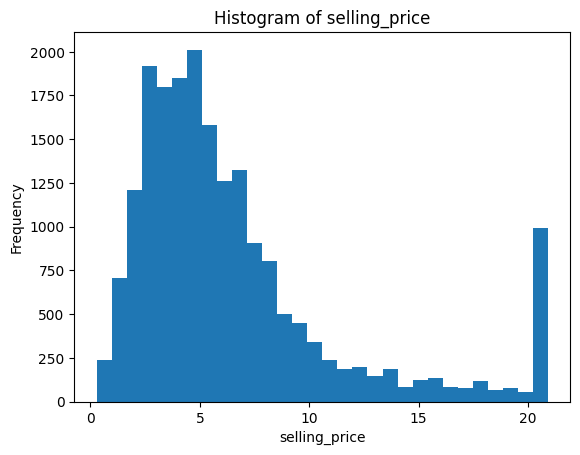

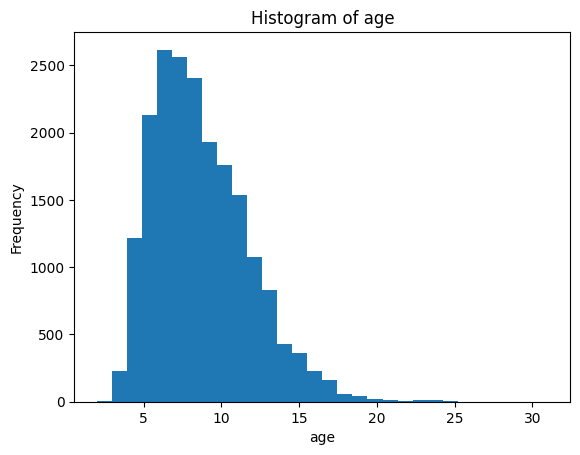

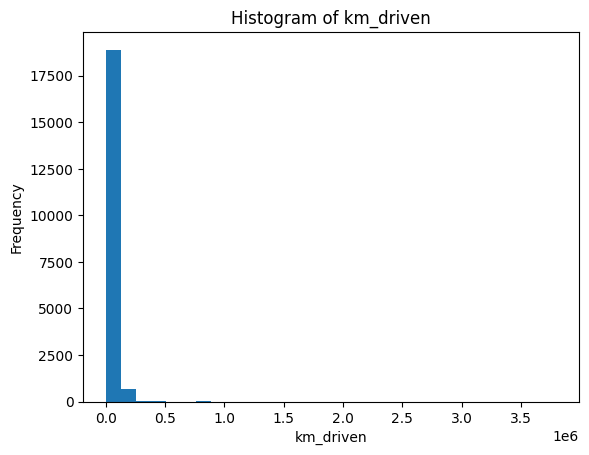

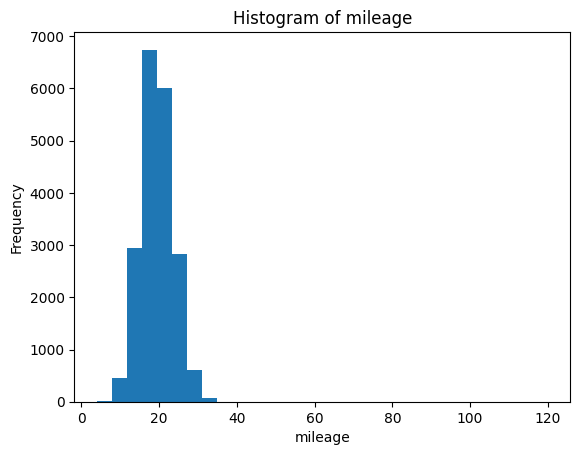

In [12]:

# Plot target histogram
if TARGET in df.columns and pd.api.types.is_numeric_dtype(df[TARGET]):
    plt.figure()
    df[TARGET].plot(kind='hist', bins=30, title=f"Histogram of {TARGET}")
    plt.xlabel(TARGET); plt.ylabel("Frequency")
    plt.show()

# Plot up to 3 numeric features' histograms
for col in numeric_cols[:3]:
    plt.figure()
    df[col].plot(kind='hist', bins=30, title=f"Histogram of {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.show()



### 📝 TODO
- Looking at the histograms, note any skewed variables or outliers.

Price and Age are right skewked with price having outliers

Mileage is mostly symmetrical and there appears no outliers

Km_driven is heavily right skewed and there are outliers

## 5) Single-Variable Linear Regression

Feature: age
Coefficient (slope): -0.5884126624392728
Intercept: 11.54834715205151
R^2 (test): 0.1589294752769993


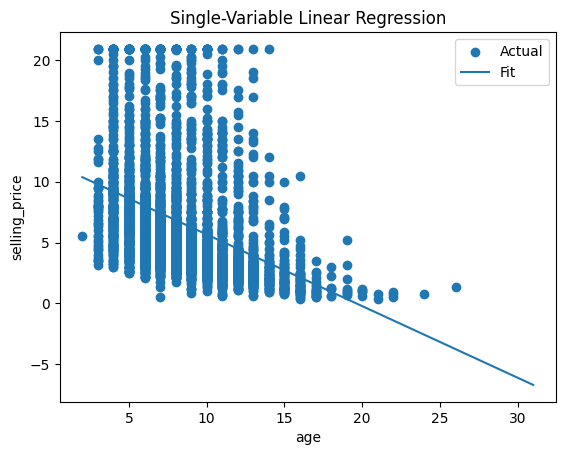

In [13]:

# Pick one feature (auto-pick the first numeric feature)
if len(numeric_cols) == 0:
    raise ValueError("No numeric predictors found. Please adjust `numeric_cols`.")

FEATURE_X = numeric_cols[0]  # change to try others

# Drop rows with missing target/feature
data_1v = df[[FEATURE_X, TARGET]].dropna().copy()

X = data_1v[[FEATURE_X]].values
y = data_1v[TARGET].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions on test set
y_pred = lr.predict(X_test)

print("Feature:", FEATURE_X)
print("Coefficient (slope):", lr.coef_[0])
print("Intercept:", lr.intercept_)
print("R^2 (test):", r2_score(y_test, y_pred))

# Plot scatter + regression line (on test set)
plt.figure()
plt.scatter(X_test, y_test, label="Actual")
# create a line
x_line = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
y_line = lr.predict(x_line)
plt.plot(x_line, y_line, label="Fit")
plt.xlabel(FEATURE_X); plt.ylabel(TARGET); plt.title("Single-Variable Linear Regression")
plt.legend()
plt.show()



### 📝 TODO
- Change `FEATURE_X` to a different column and re-run.
- Does the line slope match your intuition about the relationship?


## 6) Multi-Variable Linear Regression (Simple)

In [ ]:

# Keep only numeric predictors + target; drop NA
data_mv = df[numeric_cols + [TARGET]].dropna().copy()

X = data_mv[numeric_cols].values
y = data_mv[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin = LinearRegression()
lin.fit(X_train, y_train)

y_pred = lin.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.3f}")
print(f"MSE:  {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R^2:  {r2:.3f}")



### 📝 TODO
- Remove one weak feature from `numeric_cols` and see how metrics change.
- Add a different feature and compare.


## 7) Diagnostic Plots (Residuals)

In [ ]:

# Reuse y_test and y_pred from multi-variable model
residuals = y_test - y_pred

# Predicted vs Actual
plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title("Predicted vs Actual (Test)")
plt.show()

# Residuals vs Predicted
plt.figure()
plt.scatter(y_pred, residuals)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted"); plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

# Histogram of residuals
plt.figure()
pd.Series(residuals).plot(kind='hist', bins=30, title="Histogram of Residuals")
plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.show()



### 📝 TODO
- Do residuals look roughly centered around 0 and evenly spread?
- If not, which assumption might be violated?


## 8) Polynomial Features + Grid Search for Best Degree


Even though it's called "polynomial regression", it's still **linear regression** applied to **polynomially-expanded features**.
We'll try degrees **1 to 5** on a **single predictor** and pick the degree with the best cross-validated **R²**.


In [ ]:

# Choose a single predictor again (same FEATURE_X as before by default)
FEATURE_X = FEATURE_X  # keep same, or set to something else like 'horsepower'

poly_data = df[[FEATURE_X, TARGET]].dropna().copy()
X = poly_data[[FEATURE_X]].values
y = poly_data[TARGET].values

pipe = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("lr", LinearRegression())
])

param_grid = {
    "poly__degree": [1, 2, 3, 4, 5],
    "lr__fit_intercept": [True, False]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Best CV R^2:", grid.best_score_)

best_model = grid.best_estimator_

# Plot best curve
x_line = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
y_line = best_model.predict(x_line)

plt.figure()
plt.scatter(X, y, s=12)
plt.plot(x_line, y_line)
plt.xlabel(FEATURE_X); plt.ylabel(TARGET)
plt.title("Best Polynomial Fit (via Grid Search)")
plt.show()



### 📝 TODO
- Change the degree range (e.g., 1–8) and re-run. Does performance keep improving?
- Try a different `FEATURE_X`.


## 9) Interpreting Coefficients (Multi-Variable Model)

In [ ]:

# Show top coefficients by magnitude (multi-variable linear model)
coef = lin.coef_
coef_df = pd.DataFrame({"feature": numeric_cols, "coefficient": coef})
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df.sort_values("abs_coef", ascending=False, inplace=True)
coef_df.drop(columns=["abs_coef"], inplace=True)
coef_df.head(10)



### 📝 TODO
- Which features have the largest (absolute) coefficients?
- Do the signs (+/-) match your intuition?



## 10) Linear Regression — Quick Assumptions Checklist
- **Linearity**: Relationship between predictors and target is roughly linear.
- **Independence**: Errors are independent.
- **Homoscedasticity**: Residuals have constant variance.
- **Normality (for inference)**: Residuals are roughly normal.
- **No perfect multicollinearity**: Avoid duplicate/linearly dependent features.



## 11) Assumption Checks — Code You Can Run
We'll check the classic linear regression assumptions using simple, readable code:
- **Linearity & Homoscedasticity:** residuals vs predicted plot
- **Normality of residuals:** Q–Q plot and Shapiro–Wilk test
- **Independence of errors:** Durbin–Watson statistic
- **Multicollinearity:** Variance Inflation Factor (VIF)


In [ ]:

#@title Install test libs (statsmodels) if needed
import sys, subprocess
def pip_install(pkg):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=False)

try:
    import statsmodels
except:
    pip_install("statsmodels>=0.14")
    import statsmodels

from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# NOTE: This cell assumes you've already run the multi-variable model section
# so that y_test, y_pred, X_train, X_test, numeric_cols, TARGET are defined.
# If not, re-run sections 6 and 7.


In [ ]:

# 11.1 Linearity & Homoscedasticity (visual)
# Residuals vs Predicted should look like a random cloud around 0 (no pattern / fanning)

residuals = y_test - y_pred

plt.figure()
plt.scatter(y_pred, residuals, s=14)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

print("🧐 Look for: no obvious curve/pattern; spread roughly constant across x-axis.")


In [ ]:

# 11.2 Normality of residuals: Q–Q plot + Shapiro–Wilk test
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q–Q Plot of Residuals")
plt.show()

sh_stat, sh_p = stats.shapiro(residuals)
print(f"Shapiro–Wilk: statistic={sh_stat:.3f}, p-value={sh_p:.3g}")
print("Rule of thumb: p-value > 0.05 suggests residuals are close to normal (for inference).")


In [ ]:

# 11.3 Independence of errors: Durbin–Watson (≈2 is good; <1 or >3 indicates strong autocorrelation)
dw = durbin_watson(residuals)
print(f"Durbin–Watson statistic = {dw:.3f}")
print("Guideline: ~2 means uncorrelated; much below 2 ⇒ positive autocorrelation; much above 2 ⇒ negative autocorrelation.")


In [ ]:

# 11.4 Homoscedasticity formal test: Breusch–Pagan
# Use original predictors (X_test). Add constant for the test design matrix.

X_bp = sm.add_constant(pd.DataFrame(X_test, columns=numeric_cols))
bp_stat, bp_p, _, _ = het_breuschpagan(residuals, X_bp)
print(f"Breusch–Pagan: stat={bp_stat:.3f}, p-value={bp_p:.3g}")
print("Rule of thumb: p-value > 0.05 ⇒ no strong evidence of heteroscedasticity.")


In [ ]:

# 11.5 Multicollinearity: VIF (on training predictors)
X_vif = pd.DataFrame(X_train, columns=numeric_cols).dropna()
X_vif_const = sm.add_constant(X_vif, has_constant='add')

vif_vals = []
for i, col in enumerate(X_vif_const.columns):
    if col == 'const':
        continue
    vif_vals.append({"feature": col, "VIF": variance_inflation_factor(X_vif_const.values, i+1)})

vif_df = pd.DataFrame(vif_vals).sort_values("VIF", ascending=False)
vif_df



### 📝 TODO
- If **Breusch–Pagan p < 0.05**, try transforming a skewed feature (e.g., `np.log1p(x)`) and re-fit.  
- If **Shapiro p < 0.05**, consider outliers or feature transforms.  
- If **VIF > 10** for a feature, try removing it or combining highly correlated features.  
- If **Durbin–Watson** is far from 2 (time-indexed data), try adding lag features or using time-series models.
